In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Conv2d, InstanceNorm2d, ConvTranspose2d
from torch import optim 
import torch.nn.functional as F 
import torchvision

from torchvision.utils import save_image, make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this won't work if the drive is shared with you
# solution: right click on the shared ML project folder and select 'add shortcut to my drive'
%cd gdrive/My\ Drive/CS7643_Final_Project

/content/gdrive/My Drive/CS7643_Final_Project


In [ ]:
class bVAE(nn.Module):
  def __init__(self, latent_dim):
    super(bVAE, self).__init__()
    self.latent_dim = latent_dim
    # Encoder
    self.c1 = nn.Conv2d(1, 32, kernel_size = 4, stride = 2, padding = 1)
    self.b1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
    self.b2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.b3 = nn.BatchNorm2d(64)

    self.fc1 = nn.Linear(64 * 6 * 6, latent_dim)
    self.fc2 = nn.Linear(64 * 6 * 6, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, 64 * 6 * 6)
    self.d1 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.db1 = nn.BatchNorm2d(64)
    self.d2 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1)
    self.db2 = nn.BatchNorm2d(32)
    self.d3 = nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2, padding = 1)
    self.db3 = nn.BatchNorm2d(1)
    self.sigmoid = nn.Sigmoid()
  
  def encode(self, x):
    out = F.relu(self.b1(self.c1(x)))
    out = F.relu(self.b2(self.c2(out)))
    out = F.relu(self.b3(self.c3(out)))
    # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
    out = out.view(out.shape[0], -1)
    mu, logvar = F.relu(self.fc1(out)), F.relu(self.fc2(out))
    return mu, logvar
  
  def decode(self, z):
    out = F.relu(self.fc3(z))
    out = out.view(-1, 64, 6, 6)
    out = F.relu(self.db1(self.d1(out)))
    out = F.relu(self.db2(self.d2(out)))
    return self.sigmoid(self.db3(self.d3(out)))
  
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
class VAE_Loss(nn.Module):
  def __init__(self):
    super(VAE_Loss, self).__init__()
    self.beta = 3
  
  def forward(self, z_img, img, mu, logvar):
    BCE = torch.mean(F.binary_cross_entropy(z_img, img, reduction='sum'), dim = 0)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
    return BCE + self.beta * KLD

In [ ]:
batch_size = 128

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=32, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print('Training samples: ', len(train_data_loader.dataset))

Training samples:  60000


In [ ]:
print('Testing samples: ', len(test_data_loader.dataset))

Testing samples:  10000


In [ ]:
model = bVAE(20).to(device)
optimizer = optim.Adam(params = model.parameters(), lr=5e-3)
criterion = VAE_Loss()

In [ ]:
fixed_images, _ = next(iter(test_data_loader))

In [ ]:
def generate_samples(images, model):
  with torch.no_grad():
    out, _, _ = model(images)
  return out

In [ ]:
def evaluate_model(model, dataloader):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    loss = 0
    n = 0
    with torch.no_grad():
      for xs, _ in dataloader:
        xs = xs.to(device)
        out, mu, logvar = model(xs)
        loss += criterion(out, xs, mu, logvar).item()
        n += 1
    
    print(f'\nTest loss: {loss / n: .2f}')
    return loss / n

In [ ]:
epochs = 80
losses = []
best_loss = float('inf')

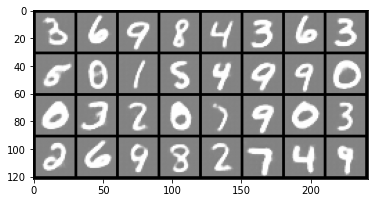

Epoch: 1, Avg Loss: -110996.1232


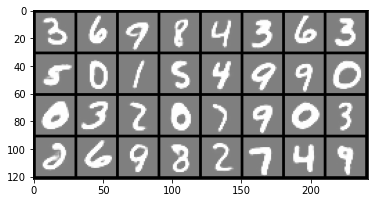

Epoch: 2, Avg Loss: -323010.4108
Epoch: 3, Avg Loss: -688599.1752


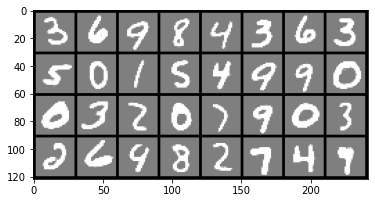

Epoch: 4, Avg Loss: -1131553.6245
Epoch: 5, Avg Loss: -1501205.8100


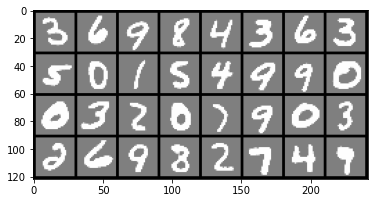

Epoch: 6, Avg Loss: -1801204.1261
Epoch: 7, Avg Loss: -2052185.0232


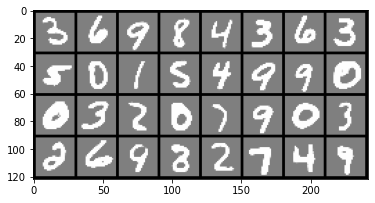

Epoch: 8, Avg Loss: -2270578.8739
Epoch: 9, Avg Loss: -2452252.6607


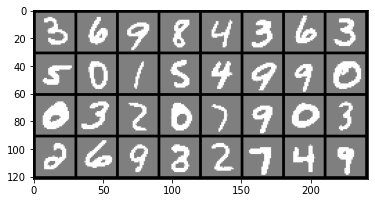

Epoch: 10, Avg Loss: -2536951.7924
Epoch: 11, Avg Loss: -2587682.8806


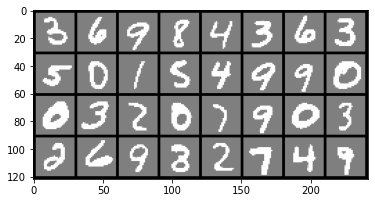

Epoch: 12, Avg Loss: -2626734.2735
Epoch: 13, Avg Loss: -2658689.7588


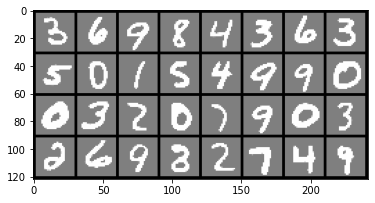

Epoch: 14, Avg Loss: -2683755.0864
Epoch: 15, Avg Loss: -2706211.0970


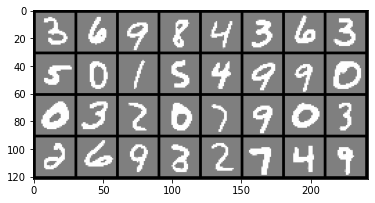

Epoch: 16, Avg Loss: -2728324.9704
Epoch: 17, Avg Loss: -2748528.5943


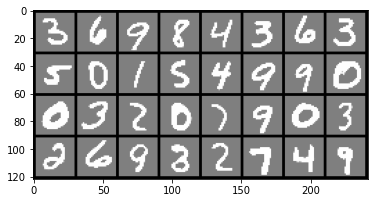

Epoch: 18, Avg Loss: -2766588.9619
Epoch: 19, Avg Loss: -2785278.6903


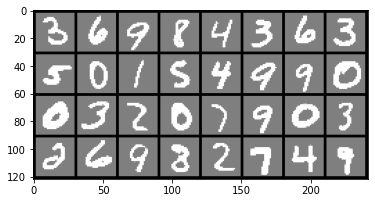

Epoch: 20, Avg Loss: -2802439.0149
Epoch: 21, Avg Loss: -2819339.6034


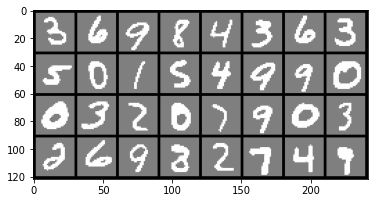

Epoch: 22, Avg Loss: -2837216.9973
Epoch: 23, Avg Loss: -2854316.9542


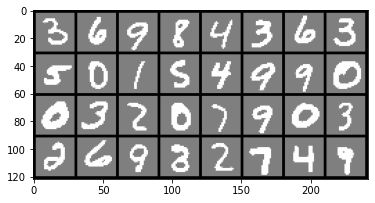

Epoch: 24, Avg Loss: -2871493.3321
Epoch: 25, Avg Loss: -2888040.9147


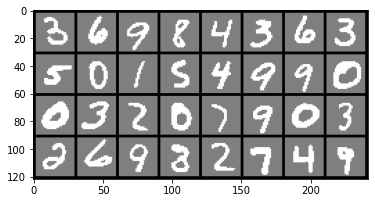

Epoch: 26, Avg Loss: -2904804.4003
Epoch: 27, Avg Loss: -2921285.1732


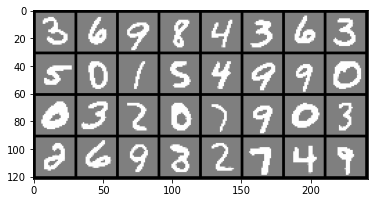

Epoch: 28, Avg Loss: -2937289.5405
Epoch: 29, Avg Loss: -2952113.0432


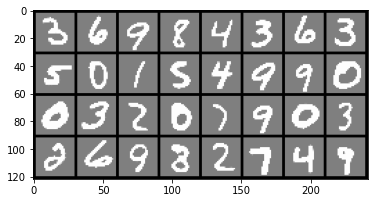

Epoch: 30, Avg Loss: -2967236.0288
Epoch: 31, Avg Loss: -2980319.3284


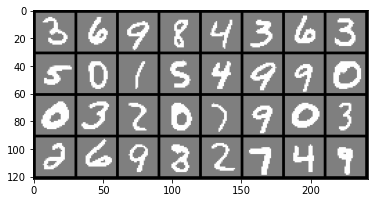

Epoch: 32, Avg Loss: -2993346.9749
Epoch: 33, Avg Loss: -3007093.9574


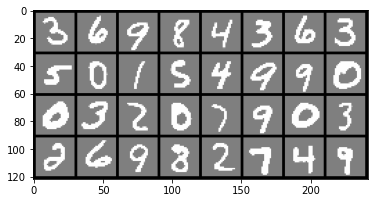

Epoch: 34, Avg Loss: -3018752.8886
Epoch: 35, Avg Loss: -3031292.9200


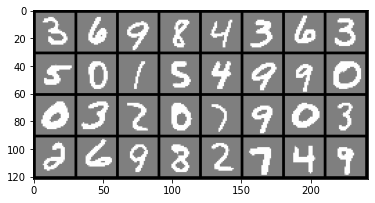

Epoch: 36, Avg Loss: -3042386.4808
Epoch: 37, Avg Loss: -3053366.8918


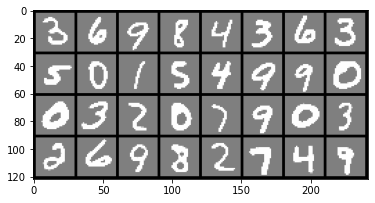

Epoch: 38, Avg Loss: -3063712.1157
Epoch: 39, Avg Loss: -3074465.9664


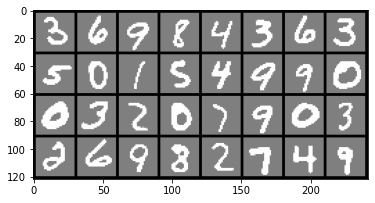

Epoch: 40, Avg Loss: -3084491.2921
Epoch: 41, Avg Loss: -3093841.0208


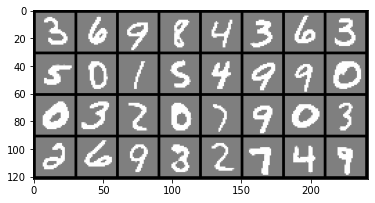

Epoch: 42, Avg Loss: -3103934.7958
Epoch: 43, Avg Loss: -3112367.4776


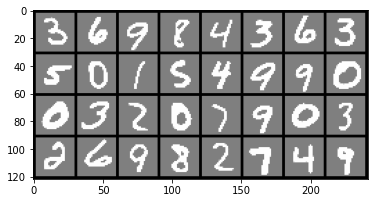

Epoch: 44, Avg Loss: -3121600.8635
Epoch: 45, Avg Loss: -3130636.7655


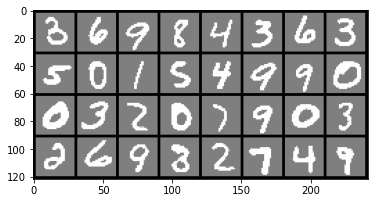

Epoch: 46, Avg Loss: -3138863.1668
Epoch: 47, Avg Loss: -3146938.5101


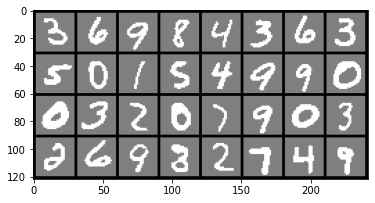

Epoch: 48, Avg Loss: -3155263.7473
Epoch: 49, Avg Loss: -3163164.4094


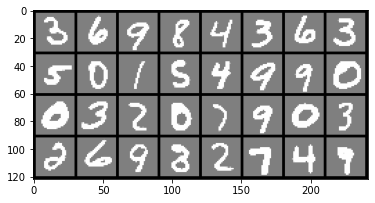

Epoch: 50, Avg Loss: -3170378.0805
Epoch: 51, Avg Loss: -3177996.9248


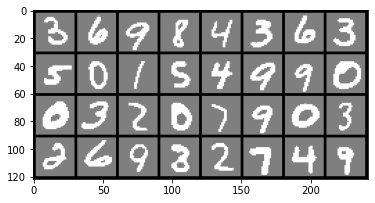

Epoch: 52, Avg Loss: -3185787.8028
Epoch: 53, Avg Loss: -3193073.5293


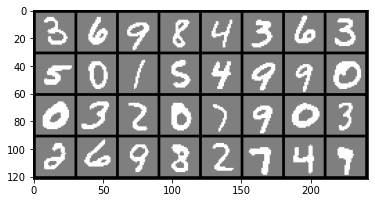

Epoch: 54, Avg Loss: -3200200.7852
Epoch: 55, Avg Loss: -3207378.2159


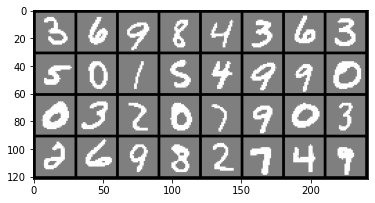

Epoch: 56, Avg Loss: -3214236.8897
Epoch: 57, Avg Loss: -3220934.7623


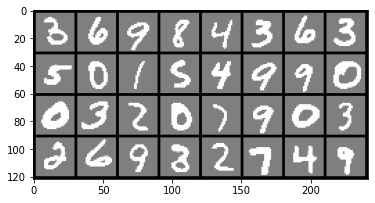

Epoch: 58, Avg Loss: -3227827.3795
Epoch: 59, Avg Loss: -3234436.6914


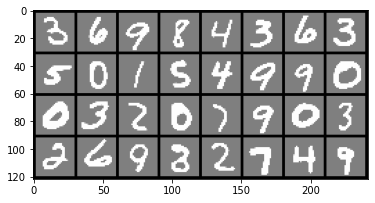

Epoch: 60, Avg Loss: -3241989.1434
Epoch: 61, Avg Loss: -3247944.4883


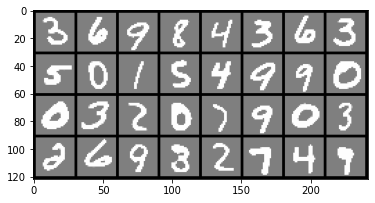

Epoch: 62, Avg Loss: -3254049.9302
Epoch: 63, Avg Loss: -3260318.7580


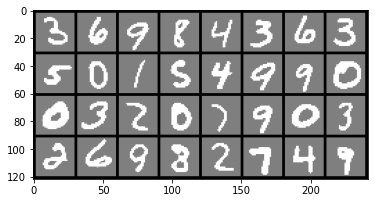

Epoch: 64, Avg Loss: -3265784.5821
Epoch: 65, Avg Loss: -3271868.7825


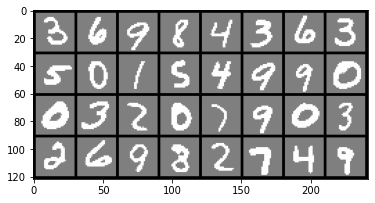

Epoch: 66, Avg Loss: -3277986.2409
Epoch: 67, Avg Loss: -3284214.1999


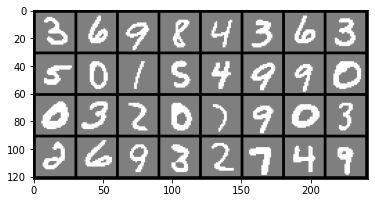

Epoch: 68, Avg Loss: -3289580.2409
Epoch: 69, Avg Loss: -3295989.1109


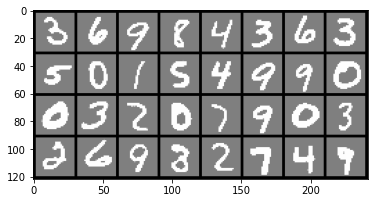

Epoch: 70, Avg Loss: -3301056.0853
Epoch: 71, Avg Loss: -3306528.5816


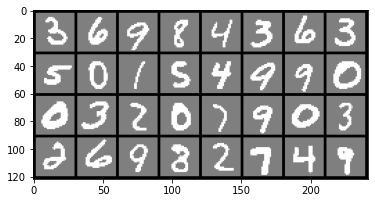

Epoch: 72, Avg Loss: -3312092.4019
Epoch: 73, Avg Loss: -3317891.7042


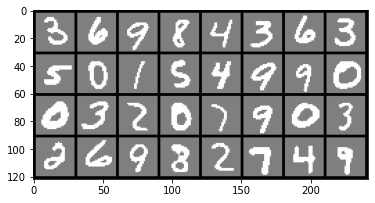

Epoch: 74, Avg Loss: -3323549.7681
Epoch: 75, Avg Loss: -3328361.2996


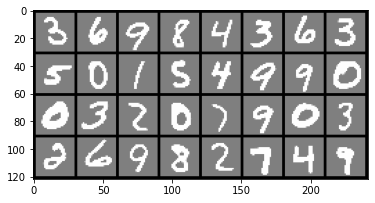

Epoch: 76, Avg Loss: -3333943.3795
Epoch: 77, Avg Loss: -3338390.6295


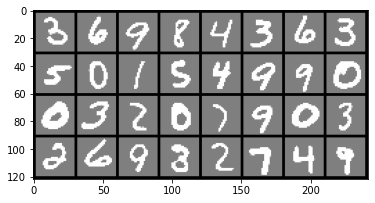

Epoch: 78, Avg Loss: -3344238.5581
Epoch: 79, Avg Loss: -3349095.7783


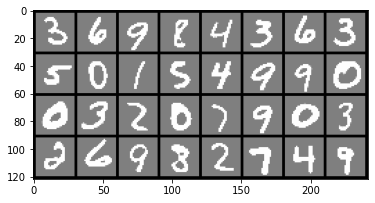

Epoch: 80, Avg Loss: -3354358.6194


In [ ]:
for epoch in range(1, epochs + 1):
  total = 0
  n = 0
  for x, _ in train_data_loader:
    x = x.to(device)
    optimizer.zero_grad()
    out, mu, logvar = model(x)
    loss = criterion(out, x, mu, logvar)
    loss.backward()
    optimizer.step()

    total += loss.item()
    n += 1
  
  avg_loss = total / n
  losses.append(avg_loss)

  if avg_loss < best_loss:
    best_loss = avg_loss
    with open('bVAE.pt', 'wb') as f:
      torch.save(model.state_dict(), f)
  
  if epoch == 1 or epoch % 2 == 0:
    model.eval()
    outputs = generate_samples(fixed_images.to(device), model)
    grid = make_grid(outputs.cpu(), nrow=8, range=(-1, 1), normalize=True)
    plt.imshow(grid.detach().permute(1, 2, 0))
    plt.show()
    model.train()

  print('Epoch: {}, Avg Loss: {:.4f}'.format(epoch, avg_loss))
  epoch += 1

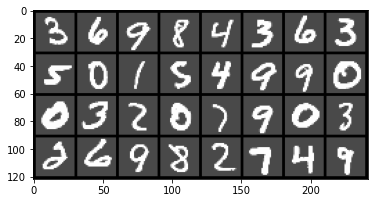

In [ ]:
# plot the actual test images
grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0))
plt.show()

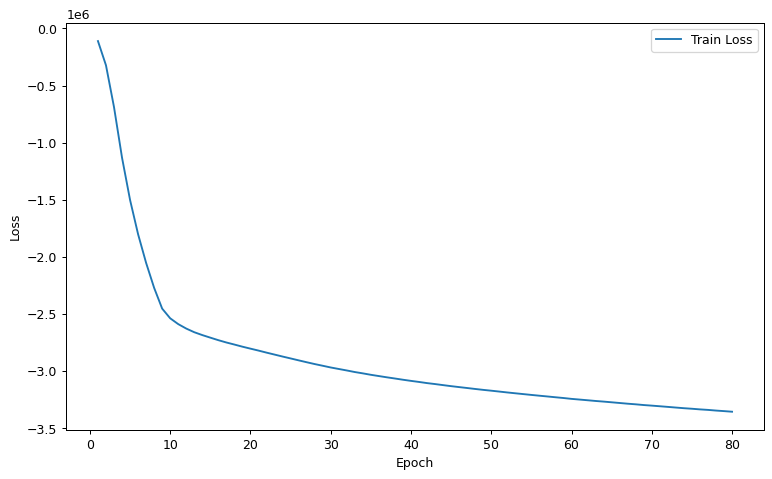

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 90
plt.plot(list(range(1, epochs + 1)), losses)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

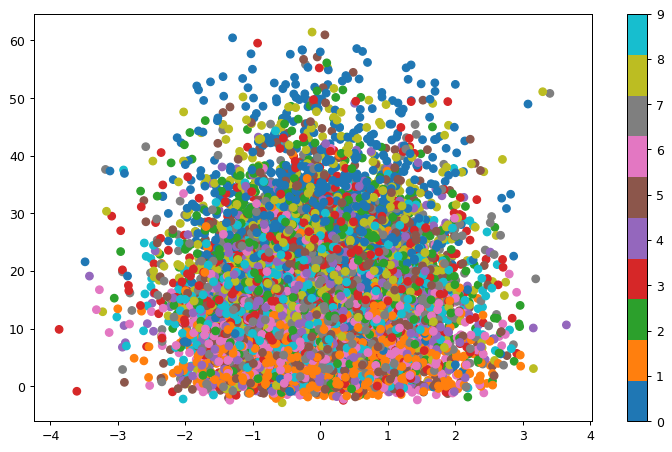

In [ ]:
# visualize latent space
for i, (x, y) in enumerate(test_data_loader):
  mu, logvar = model.encode(x.to(device))
  z = model.reparameterize(mu, logvar)
  z = z.to('cpu').detach().numpy()
  plt.scatter(z[:, 0], z[:, 1], c = y, cmap = 'tab10')
plt.colorbar()

In [ ]:
evaluate_model(model, test_data_loader)


Test loss: -833113.77


-833113.7736621406